# Imports

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy as sp
import os
import glob
import sys
import pandas as pd
from datetime import datetime, timedelta
import collections
import matplotlib.cm as cm
#plt.rcdefaults() #Setting default color of output plots. No need in jupyter lab. Only for notebook with dark theme
# For interactive plots

#plt.rcParams.update({'figure.max_open_warning': 0})
#%matplotlib widget
sys.path.insert(0, '/Home/siv30/wad005/useful_py_functions')
import matplotlib_custom_style_and_macros as pltmacro



# TODO:
   1) Redo all the plots ... export
   2) There might be some triggers in HED, where i havent extracted the LED file

# Paths

In [2]:
path_HED = "/Home/siv30/wad005/master/GRB/MATLAB/output/file_mat_TGF/"              #UiB
path_LED = "/Home/siv30/wad005/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF/" #UiB
#path_HED = "/Users/andreas/phys/master/GRB/MATLAB/output/file_mat_TGF/"               #MAC
#path_LED = "/Users/andreas/phys/master/GRB/MATLAB/CZT_calibration/file_mat_CZT_TGF/"  #MAC

# Dict creation

In [3]:
trig_dict_HED = {"GRB180720":["2018_07_20_14_21_48","2018_07_20_14_21_51","2018_07_20_14_21_56","2018_07_20_14_21_57","2018_07_20_14_22_09"],
                 "GRB180807":["2018_08_07_02_19_37"],
                 "GRB181103":["2018_11_03_04_22_33"],
                 "GRB181222":["2018_12_22_20_11_36"],
                 "GRB190117":["2019_01_17_08_50_43"],
                 "GRB190206":["2019_02_06_03_49_28"],
                 "GRB190305":["2019_03_05_13_05_19"],
                 "GRB190320":["2019_03_20_01_14_06"],
                 "GRB190404":["2019_04_04_07_01_05"],
                 "GRB190420":["2019_04_20_23_32_23"],
                 "GRB190501":["2019_05_01_05_23_22"],
                 "GRB190606":["2019_06_06_01_55_07"],
                 "GRB190615":["2019_06_15_14_42_21"],
                 "GRB190706":["2019_07_06_12_40_43"],
                 "GRB190813":["2019_08_13_12_00_49"],
                 "GRB190825":["2019_08_25_21_04_55","2019_08_25_21_04_53"], 
                 "GRB190829":["2019_08_29_19_56_40"],
                 "GRB190906":["2019_09_06_01_04_51"],
                 "GRB191001":["2019_10_01_06_41_52"],
                 "GRB191004":["2019_10_04_18_07_03"],
                 "GRB191119":["2019_11_19_10_41_06"],
                 "GRB191221":["2019_12_21_20_39_10","2019_12_21_20_39_11","2019_12_21_20_39_12","2019_12_21_20_39_13","2019_12_21_20_39_15"],
                 "GRB191227":["2019_12_27_17_21_45"], #Also triggered 5 seconds after. filname: "2019_12_27_17_21_49"
                 "GRB200111":["2020_01_11_15_11_12"],
                 "GRB200224":["2020_02_24_09_58_44"],
                 "GRB200415":["2020_04_15_08_48_05"],
                 "GRB200412":["2020_04_12_06_57_13", "2020_04_12_06_57_15", "2020_04_12_06_57_16", "2020_04_12_06_57_17", "2020_04_12_06_57_18", "2020_04_12_06_57_20",
                             "2020_04_12_06_57_21", "2020_04_12_06_57_22", "2020_04_12_06_57_23", "2020_04_12_06_57_24", "2020_04_12_06_57_25"] ,# long grb
                 "GRB200423":["2020_04_23_13_54_06"],
                 "GRB200521":["2020_05_21_12_16_39"],
                 "GRB200525":["2020_05_25_14_40_22"],
                 "GRB200605":["2020_06_05_18_17_42"],
                 "GRB200716":["2020_07_16_22_57_40"],
                 "GRB200812":["2020_08_12_11_55_23","2020_08_12_11_55_25"],
                 "GRB200925":["2020_09_25_21_50_31"],
                 "GRB200907":["2020_09_07_18_51_20"],
                 "GRB200915":["2020_09_15_03_27_06"],
                 "GRB200923":["2020_09_23_17_57_41"],
                 "GRB200925":["2020_09_25_21_50_31"],
                 "GRB201223":["2020_12_23_17_58_10"],
                 "GRB210102":["2021_01_02_20_38_02","2021_01_02_20_38_07"],
                 "GRB210411":["2021_04_11_13_32_30"],
                 "GRB210424":["2021_04_24_08_01_55"],
                 "GRB210607":["2021_06_07_21_39_20","2021_06_07_21_39_21","2021_06_07_21_39_22"],
                 "GRB210619":["2021_06_19_23_59_24","2021_06_19_23_59_25", "2021_06_19_23_59_26","2021_06_19_23_59_27", "2021_06_19_23_59_33", "2021_06_19_23_59_34",
                             "2021_06_19_23_59_35", "2021_06_19_23_59_36", "2021_06_19_23_59_37","2021_06_19_23_59_38"],
                 "GRB210701":['2021_07_01_20_01_00'],
                 "GRB210702":['2021_07_02_19_07_09','2021_07_02_19_07_10','2021_07_02_19_07_12'],
                 "GRB210724":["2021_07_24_20_14_03"],
                 "GRB201109":["2020_11_09_02_31_08"],
                 "GRB210903":["2021_09_03_17_26_58"],
                 "GRB211118":["2021_11_18_23_38_04"],
                 "GRB211211":["2021_12_11_13_10_01","2021_12_11_13_10_02","2021_12_11_13_10_05","2021_12_11_13_10_06","2021_12_11_13_10_15","2021_12_11_13_10_17",
                              "2021_12_11_13_10_18","2021_12_11_13_10_19"],
                 "GRB201227":['2020_12_27_15_14_06']
                 }
trig_dict_HED = collections.OrderedDict(sorted(trig_dict_HED.items())) #Sorting the keys in decending order. Now trig_dict_HED is an OderedDict type

for key in trig_dict_HED.keys():
    trig_dict_HED[key].sort() #sorting files in increasing order

In [4]:
trig_dict_LED = {"GRB181227":["2018.12.27_06.17.04.210500_Fulltrigger","2018_12_27_06_17_09.775992_Fulltrigger","2018_12_27_06_17_10.800851_Fulltrigger"],
                 "GRB181103":["2018.11.03_04.22.34.566125_Fulltrigger"],
                 "GRB190117":["2019.01.17_08.50.42.939689_Fulltrigger"],
                 "GRB190404":['2019.04.04_07.01.06.584820_Fulltrigger'],
                 "GRB190420":["2019.04.20_23.32.24.931211_Fulltrigger"],
                 "GRB190501":["2019.05.01_05.23.21.736797_Fulltrigger"],
                 "GRB190615":["2019.06.15_14.42.22.741579_Fulltrigger"],
                 "GRB190628":["2019.06.28_04.23.32.512290_Fulltrigger"],
                 "GRB190813":["2019.08.13_12.00.48.801260_Fulltrigger"],
                 "GRB190825":["2019.08.25_21.04.54.439617_Fulltrigger","2019.08.25_21.04.56.395859_Fulltrigger"],
                 "GRB190906":["2019.09.06_01.04.52.014004_Fulltrigger"],
                 "GRB191001":["2019.10.01_06.41.51.631214_Fulltrigger"],
                 "GRB191004":["2019.10.04_18.07.03.402478_Fulltrigger"],
                 "GRB191119":["2019.11.19_10.41.05.239944_Fulltrigger"],
                 "GRB191221":["2019.12.21_20.39.11.939846_Fulltrigger","2019.12.21_20.39.12.939997_Fulltrigger","2019.12.21_20.39.13.940233_Fulltrigger",
                              "2019.12.21_20.39.15.106045_Fulltrigger","2019.12.21_20.39.17.252498_Fulltrigger"],
                 "GRB191227":["2019.12.27_17.21.45.549390_Fulltrigger"], # Also triggered 5 sec after. filename: "2019.12.27_17.21.50.236046_Fulltrigger"
                 "GRB200111":["2020.01.11_15.11.13.187473_Fulltrigger"],
                 "GRB200122":["2020.01.22_05.18.10.228382_Fulltrigger"],
                 "GRB200224":["2020.02.24_09.58.44.448334_Fulltrigger"],
                 "GRB200412":["2020.04.12_06.57.15.879304_Fulltrigger", "2020.04.12_06.57.16.879531_Fulltrigger", "2020.04.12_06.57.17.879742_Fulltrigger",
                             "2020.04.12_06.57.18.880468_Fulltrigger"],
                 "GRB200415":["2020.04.15_08.48.05.470385_Fulltrigger"], #Giant magetar flare
                 "GRB200423":["2020.04.23_13.54.06.572991_Fulltrigger"],
                 "GRB200525":["2020.05.25_14.40.22.951437_Fulltrigger"],
                 "GRB200605":["2020.06.05_18.17.42.165859_Fulltrigger"],
                 "GRB200812":["2020.08.12_11.55.24.308429_Fulltrigger","2020.08.12_11.55.26.144703_Fulltrigger"],
                 "GRB200903":["2020.09.03_21.38.50.495317_Fulltrigger"],
                 "GRB200907":["2020.09.07_18.51.20.724118_Fulltrigger"],
                 "GRB200915":["2020.09.15_03.27.06.777086_Fulltrigger"],
                 "GRB200923":["2020.09.23_17.57.42.645020_Fulltrigger"],
                 "GRB201109":["2020.11.09_02.31.09.400868_Fulltrigger"],
                 "GRB210102":["2021.01.02_20.38.02.245585_Fulltrigger","2021.01.02_20.38.07.079069_Fulltrigger"],
                 "GRB210424":["2021.04.24_08.01.55.875520_Fulltrigger"],
                 "GRB210607":["2021.06.07_21.39.21.187641_Fulltrigger","2021.06.07_21.39.22.204550_Fulltrigger","2021.06.07_21.39.23.317169_Fulltrigger"],
                 
                }
trig_dict_LED = collections.OrderedDict(sorted(trig_dict_LED.items())) #Sorting the keys in decending order. Now trig_dict_HED is an OderedDict type

for key in trig_dict_LED.keys():
    trig_dict_LED[key].sort() #sorting files in increasing order

# Functions for handling matlab files

## CZT function

In [5]:
def read_matlab_file_with_CZT_data(filename):
    '''Read matlab file with ASIM CZT data from the low energy detector (LED)

    tus: relative time in microseconds (excluded multihits)
    erg: energy channel (excluded multihits)
    energy_keV: energy in keV (excluded multihits)
    tus_keep_multihit: relative time in microseconds (included multihits)
    erg_keep_multihit: energy channel (included multihits)
    multihit_indx: multihit index 0-4. 0->1 1->2// 0: tus=105, 1: tus=110,110 (two counts)
    '''
    mat = scipy.io.loadmat(path_LED + "%s.mat" % (filename))

    #keV_spectra = mat['keV_spectra_total_fulltrigger']

    # Included multihits. Important for light curves
    tus_keep_multihit = np.array(mat['tus_keep_multihit_fulltrigger'])[:,0] # relative time in microseconds
    erg_keep_multihit = np.array(mat['erg_keep_multihit_fulltrigger'])[0,:] # energy channel (unreliable for multi hits)
    multihit_indx = np.array(mat['multihit_fulltrigger'])[0,:] # multihit index. How many multihits in count. (0=1 count, 1=2 counts, 2=3 counts...)
    
    # The multihits are removed as they don't have a reliable energy estimate
    erg = np.array(mat['erg_fulltrigger'])[0,:] # energy channel of CZT pixel
    tus = np.array(mat['tus_fulltrigger'])[:,0] # relative time in microseconds
    energy_keV = np.array(mat['pixel_energy_fulltrigger']).flatten() # energy in keV of CZT pixel
    date = mat['T_ref_char'][0] #raw datetime as string
    
    #Logic that checks for array lengths
    try:
        length = len(tus_keep_multihit)
        if any(len(lst) != length for lst in [erg_keep_multihit, multihit_indx]):
        # at least one list has a different length
            raise ValueError("Arrays have different lengths")
            
        t_temp = []
        erg_temp = []
        energy_keV_temp = []
        
        for index, i in enumerate(multihit_indx):
            for j in np.arange(0,i+1): #adding i+1 times the tus_count
                t_temp.append(tus_keep_multihit[index])
                erg_temp.append(erg_keep_multihit[index])

         
        tus_keep_multihit_ntimes =  np.array(t_temp) #array of tus. Multihit index decides how many times the tus is appended
        erg_keep_multihit_ntimes = np.array(erg_temp) #array of erg. Multihit index decides how many times the erg is appended
        
        
        return tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx, date 
    
    except ValueError as ve:
        print("Function aborted because of: " + str(ve))
        print("Length of arrays: ")
        for lst in [tus_keep_multihit, erg_keep_multihit, multihit_indx]:
            print(len(lst))

## BGO function

In [43]:
tus, erg, typ, adr, dau, det, date = read_matlab_file_with_BGO_data(trig_dict_HED["GRB190606"][0])
#print(date)

In [7]:
#tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx, date  = read_matlab_file_with_CZT_data(trig_dict_LED["GRB200903"][0])
#print(date)

In [42]:
def read_matlab_file_with_BGO_data(matlabfilename):
    '''
    TODO: Keep original version
    
    Read matlab file with ASIM BGO data from the high energy detector (HED)

    tus: relative times in microseconds.
    erg: energy channel (needs to be calibrated to keV using calibration coeff from https://git.app.uib.no/ASIM-MXGS/IN-FLIGHT_CALIBRATION_BGO/-/tree/master/CALIBRATION_COEFS )
    typ: normal (0), fast(1), valley (3), or overflow event (2 or 4 not )
    adr: BGO address 1-12
    dau: dau address 1-4
    det: detector address 1-3
    DetCol: RGB color
    
    - Kepping only normal (0) and fast (1) events
    '''
    matlabfile_TGF = path_HED + '%s.mat' % matlabfilename
    
    mat = scipy.io.loadmat(matlabfile_TGF)
    
    tus = mat['tus'].flatten()
    erg = mat['erg'].flatten()
    adr = mat['adr'].flatten()
    dau = mat['dau'].flatten()
    det = mat['det'].flatten()
    typ = mat['typ'].flatten()
    
    date = mat['date'][0] #raw datetime
    
    
    try:
        length = len(tus)
        if any(len(lst) != length for lst in [erg, typ, adr, dau, det]):
        # at least one list has a different length
            raise ValueError("Arrays have different lengths")
            
        mask = np.where((typ != 0) & (typ != 1)) #finding indecies of vallays and overflow events
        
        # removing those indecies
        tus = np.delete(tus,mask)
        erg = np.delete(erg,mask)
        adr = np.delete(adr,mask)
        dau = np.delete(dau,mask)
        det = np.delete(det,mask)
        typ = np.delete(typ,mask)
        
        
        return tus, erg, typ, adr, dau, det, date
    
    except ValueError as ve:
        print("Function aborted because of: " + str(ve))
        print("Length of arrays: ")
        for lst in [tus,erg, typ, adr, dau, det]:
            print(len(lst))

# Plotting functions

## LED

In [182]:
def plot_LED(grb_id=None, tus_arr = None, LED_filename=None, binsize=10, T0=None, export=False):
    """ Can switch between plotting by grb_id, tus_arr and LED_filename. Only one of the options at the time.
    plot_LED function can also find the background when start_range and end_range is specified"""
    
    binsize = binsize #ms
    
    
    #switch for input
    try:
        if LED_filename != None and grb_id == None and tus_arr == None:
            tus_LED, erg_LED, energy_keV_LED, tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED, date = read_matlab_file_with_CZT_data(
                LED_filename)
            T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
            time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12] # T0 HHMMSS.f
            grb_id_title = "GRB " + date_id
            
        elif grb_id != None and tus_arr == None and LED_filename == None:
            if grb_id not in trig_dict_LED.keys():
                raise KeyError("GRB ID not in dict")
            else:
                LED_filename = trig_dict_LED[grb_id][0]
                tus_LED, erg_LED, energy_keV_LED, tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED, date = read_matlab_file_with_CZT_data(
                    LED_filename)
                T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
                date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
                time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12] # T0 HHMMSS.f
                grb_id_title = "GRB " + date_id

        elif type(tus_arr) == np.ndarray and type(T0) == datetime and grb_id == None and LED_filename==None:
            tus_LED = tus_arr
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
            time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12] # T0 HHMMSS.f
            grb_id_title = "GRB " + date_id
        else:
            return "T0 <datetime> must be specified when initiating tus_arr"
        
    except KeyError as e:
        return print(e)
    
    #Plotting routine for normal histograms. Adding output path
    plt.hist(tus_LED/1e3, bins=np.arange(
        min(tus_LED/1e3), max(tus_LED/1e3) + binsize, binsize), edgecolor= "black", histtype="step")
    plt.xlabel("time [ms], binsize {} ms".format((binsize)))
    plt.ylabel("Counts per bin"),
    plt.title(grb_id_title + " , " + "T0 = " + time_id)
     
    if export == True:
        path = "/Home/siv30/wad005/master/GRB/pyplots/LED/" #EXPORT PATH
        filename = path + grb_id_title
        plt.savefig(filename)
        crop_pdf(filename)
        plt.clf()
    else:
        plt.show()

## HED

In [181]:
def plot_HED(grb_id=None, tus_arr = None, HED_filename = None, binsize=10, T0=None, export=False):
    
    """Plotting data from HED. If HED_filename is not specified, but tus_arr is: plotting the tus array without reading matlab file
        If start and end value for the GRB is not given, the data is plotted normally,
        - BINSIZE IS INITIALIZED AS MILLISECONDS
        - start_GRB & end_GRB IS INITIALIZED AS MILLISECONDS 0.5 s = 500 ms
        - tus_HED is given in microseconds
        -T0 is given as a string
        -cut_idx: array of indecies that was used to cut the tus_arr
        -export: boolean. Exported to local dir.
    """

    binsize = binsize #ms
    

    # //TODO:
    #Create switch for plotting histograms with different color for showing the tus range plotted
    #Create switch if concat in needed
    
    #switch for input
    try:
        if HED_filename != None and grb_id == None and tus_arr == None:

            tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, date = read_matlab_file_with_BGO_data(HED_filename)
            T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: GRBYYMMDD
            time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12]
            grb_id_title = "GRB " + date_id
            
        elif grb_id != None and tus_arr == None and HED_filename == None:
            
            if grb_id not in trig_dict_HED.keys():
                raise KeyError("GRB ID not in dict")
            else:
                HED_filename = trig_dict_HED[grb_id][0]
                tus_HED, erg_HED, typ_HED, adr_HED, dau_HED, det_HED, date = read_matlab_file_with_BGO_data(HED_filename)
                T0 = datetime.strptime(date, "%Y-%b-%d %H:%M:%S.%f")
                date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: GRBYYMMDD
                time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12] # T0 HHMMSS.f
                grb_id_title = "GRB " + date_id

        elif type(tus_arr) == np.ndarray and grb_id == None and type(T0) == datetime and HED_filename==None:
            tus_HED = tus_arr
            date_id = datetime.strftime(T0,format='%y%m%d') #Correct format for title of plot: YYMMDD
            time_id = datetime.strftime(T0,format='%H:%M:%S.%f')[0:12] # T0 HHMMSS.f
            grb_id_title = "GRB " + date_id
            
        else:
            return "T0 <datetime> must be specified when initiating tus_arr"
        
    except KeyError as e:
        return print(e)
    
    
    #Plotting routine for normal histograms. Adding output path
    plt.hist(tus_HED/1e3, bins=np.arange(
            min(tus_HED/1e3), max(tus_HED/1e3) + binsize, binsize),edgecolor= "black", histtype="step")

    plt.xlabel("time [ms], binsize = {} ms".format((binsize)))
    plt.ylabel("Counts per bin"),
    plt.title(grb_id_title + " , " + "T0 = " + time_id)

    if export == True:
        path = "/Home/siv30/wad005/master/GRB/pyplots/HED/" #EXPORT PATH
        filename = path + grb_id_title
        plt.savefig(filename)
        crop_pdf(filename)
        plt.clf()
    else:
        plt.show()

# Concatination of multiple files

## Find nearest index

In [13]:
def find_nearest(array, value):
    """Returns nearest index for value in array.
    """
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

## Cutting index

In [14]:
def find_cut_idx(tus1=None, tus2=None, erg1=None, erg2=None, index_file=None):
    """TODO:
    - Search a region. Kind of like Newton iteration. If the cutoff index lies behind, the routine has a problem.
    """

    idx = find_nearest(tus1,tus2[0])
    if np.all(erg1[idx:] == erg2[0:len(erg1[idx:])]) == False:
        idx_nearest_erg = find_nearest(erg1[idx:], erg2[0]) #assuming the correct cutoff lies ahead. Might cause problems. Could search a region
        cut_idx = idx_nearest_erg + idx
        if np.all(erg1[cut_idx:] == erg2[0:len(erg1[cut_idx:])]) == True: #Checking if the energies lines up
            print("found overlapping erg array. Concatenating two files ...")
            return cut_idx
        else:
            print("No overlapping data. Reason: ergs dont line up....." + "file num: ",index_file, " cutting at idx: :", idx )
            if tus1[idx] < tus2[0]: #must be an increase in time for stitching
                return idx 
    #should check if the previous ergs line up
    else:
        print("found index on firts try. ergs line up")
        return idx #found correct stich index on first try

## concat_GRB

In [15]:
# the function is not concating correctly. 

In [129]:
def concat_GRB(grb_id, flag):
    """ function concat_files concatenates multiple matlab files. Can only concat HED or LED files at the time
    
    Flag determines whether the input list is of HED or LED files
    
    --> If there is "missing counts" between the files. 0 counts is added for the respective missing time interval. Automatically when time-shifted (?)
    
    Routine description: 
    1) The different tus arrays have their own T0. Calculating the delta T between T0 and Tn (time for concatination)  
    
    
    Parameters:
    %---------------------------------------------------------------
    
    grb_id <string>  : key for dictionary containing list of matlab filenames
    flag <string>    : "HED" or "LED". They have different arrays after calling read_matlab_file function. This flag handles that.
    
    
    returns:
    %---------------------------------------------------------------
    
    
    output for HED:
    %---------------------------------------------------------------
    concat_tus_HED <array> : concat tus (relative times in microseconds) for all arrays
    concat_erg_HED <array> : concat erg (energy channel (needs to be calibrated to keV using calibration coeff)) for all arrays
    concat_typ_HED <array> : concat typ for all counts  (normal (0), fast(1), valley (3), or overflow event (2 or 4 not )) read function keeps only 0 & 1.
    concat_adr_HED <array> : concat BGO address 1-12 for all arrays
    concat_dau_HED <array> : concat dau address 1-4
    concat_det_HED <array> : concat detector address 1-3
    T0 <datetime> : datetime object of T0
    
    output for LED:
    %----------------------------------------------------------------
    
    
    """
    #Handling input is in the right format
    
    try:
        if type(flag) and type(grb_id) != str:
            raise TypeError("grb_id and/or flag input is not string")
        elif flag != "HED" and flag != "LED":
            raise NameError("flag-string is neither HED or LED")
        elif flag == "HED":
            if grb_id not in trig_dict_HED.keys():
                raise KeyError("GRB ID not in trig_dict_HED")
            else:
                HED_files = trig_dict_HED[grb_id]       
        elif flag == "LED":
            if grb_id not in trig_dict_LED.keys():
                raise KeyError("GRB ID not in trig_dict_LED")
            else:
                LED_files = trig_dict_LED[grb_id]
                
        else:
            if flag == "HED":
                if all(HED_files[i] <= HED_files[i+1] for i in range(len(HED_files) - 1)) == False: #logic for checking that the files are in increasing order
                    raise IndexError("List is not sorted in increasing order")
            elif flag == "LED":
                print(len(LED_files))
                if all(LED_files[i] <= LED_files[i+1] for i in range(len(LED_files) - 1)) == False: #logic for checking that the files are in increasing order
                    raise IndexError("List is not sorted in increasing order")
            else:
                print("No flag")
                    
    except (TypeError, NameError, KeyError) as e:
        return print(e) #routine quits if error is found
    
    except IndexError:
        if flag == "HED":
            HED_files.sort() #sorting filenames in increasing order. Should already be done in dict creation, but good to check
        else:
            LED_files.sort() #sorting filenames in increasing order. Should already be done in dict creation, but good to check      
    try: 
        
        if flag == "HED":
            data = [] #list that stores dictionary for each file
            num_files = len(HED_files)
            
            for filename in HED_files:
                
                tus, erg, typ, adr, dau, det, date = read_matlab_file_with_BGO_data(filename)
                if len(date) != 27:
                    raise ValueError("length of datetime string is not in correct format")
                
                index_sort = np.argsort(tus, kind="mergesort") # sorting tus in increasing order. Mergesort will not be affected by floating point error
                
                tus_sort, erg_sort, typ_sort, adr_sort, dau_sort, det_sort = tus[index_sort], erg[index_sort], typ[index_sort], adr[index_sort],dau[index_sort], det[index_sort] #Making sure that the are coherent
                
                file_dict = {"tus":tus_sort, "erg":erg_sort, "typ":typ_sort, "adr":adr_sort, "dau":dau_sort, "det": det_sort, "date":date}
                
                data.append(file_dict)
            
            T0 = datetime.strptime(data[0]["date"], "%Y-%b-%d %H:%M:%S.%f") #T0 of first file. Will be T0 for concat tus array

            # Adding the timeshift to all tus arrays from T0
            for i in np.arange(1,num_files):
                deltaT = datetime.strptime(data[i]["date"], "%Y-%b-%d %H:%M:%S.%f") - T0
                data[i]["tus"] = data[i]["tus"] + float(deltaT.total_seconds())*1e6 #deltaT to all entries from T0

            # Cutting arrays at respective index; idx
            i = 0
            while i < num_files-1: #Need num_files-1 cutting indecies

                idx = find_cut_idx(tus1=data[i]["tus"], tus2=data[i+1]["tus"], erg1= data[i]["erg"] , erg2 = data[i+1]["erg"], index_file= i) #index for cutting     
                data[i]["tus"] = data[i]["tus"][:idx] #cutting arrays at idx
                data[i]["erg"] = data[i]["erg"][:idx] 
                data[i]["typ"] = data[i]["typ"][:idx]
                data[i]["dau"] = data[i]["dau"][:idx]
                i += 1

            #Concatenating respective arrays
            concat_tus_HED = np.concatenate([data[i]["tus"] for i in range(0,num_files)]) #Just concatinating tus arrays 
            concat_erg_HED = np.concatenate([data[i]["erg"] for i in range(0,num_files)])
            concat_typ_HED = np.concatenate([data[i]["typ"] for i in range(0,num_files)])
            concat_dau_HED = np.concatenate([data[i]["dau"] for i in range(0,num_files)])
            
            return concat_tus_HED, concat_erg_HED, T0 #, concat_typ_HED, concat_dau_HED, DetCol,
        
        #LED concatination
        elif flag == "LED":
            data = []
            num_files = len(LED_files)
                
            for filename in LED_files:
                
                #Working only with 
                tus, erg, energy_keV, tus_keep_multihit_ntimes, erg_keep_multihit_ntimes, multihit_indx, date = read_matlab_file_with_CZT_data(filename)
                if len(date) != 27:
                    raise ValueError("length of datetime string is not in correct format")
                
                index_sort = np.argsort(tus_keep_multihit_ntimes, kind="mergesort") # sorting tus in increasing order. Mergesort will not be affected by floating point error
                
                tus_sort, erg_sort = tus_keep_multihit_ntimes[index_sort], erg_keep_multihit_ntimes[index_sort] #Making sure that the are coherent
                
                file_dict = {"tus":tus_sort, "erg":erg_sort, "date":date}
                
                data.append(file_dict)
            
            T0 = datetime.strptime(data[0]["date"], "%Y-%b-%d %H:%M:%S.%f") #T0 of first file. Will be T0 for concat tus array

            # Adding the timeshift to all tus arrays from T0
            for i in np.arange(1,num_files):
                deltaT = datetime.strptime(data[i]["date"], "%Y-%b-%d %H:%M:%S.%f") - T0
                data[i]["tus"] = data[i]["tus"] + float(deltaT.total_seconds())*1e6 #deltaT to all entries from T0

            # Cutting arrays at respective index; idx
            i = 0
            while i < num_files-1: #Need num_files-1 cutting indecies

                idx = find_cut_idx(tus1=data[i]["tus"], tus2=data[i+1]["tus"], erg1= data[i]["erg"] , erg2 = data[i+1]["erg"], index_file= i) #index for cutting     
                data[i]["tus"] = data[i]["tus"][:idx] #cutting arrays at idx
                data[i]["erg"] = data[i]["erg"][:idx]  #cutting arrays at idx
                
                i += 1

            #Concatenating respective arrays
            concat_tus_LED = np.concatenate([data[i]["tus"] for i in range(0,num_files)]) #concatinating tus arrays 
            concat_erg_LED = np.concatenate([data[i]["erg"] for i in range(0,num_files)])

            
            
            # //TODO: return the cutting indecies
            return concat_tus_LED, concat_erg_LED, T0
        
        else:
            print("No flag of type of GRB provided")
            
    except (ValueError) as e:
        return print(e)

## Testing concat

## Converting eps to pdf

In [37]:
#Will convert all files in path
def convert_eps_files_to_pdf_files(path):
    for f in os.listdir(path):
        command = "epstopdf %s%s" % (path,f)
        print(command)
        os.system(command)
    return 0

## Cropping pdf

In [191]:
#Will crop all pdf in path f
def crop_pdf(f):
    command = "pdfcrop --margins '1 1 1 1' %s %s" % (f, f)
    print(command)
    os.system(command)
    return 0

In [210]:
ff = "/Home/siv30/wad005/master/GRB/source/LED/GRB 181103.pdf"
crop_pdf(ff)

pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/source/LED/GRB 181103.pdf /Home/siv30/wad005/master/GRB/source/LED/GRB 181103.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


0

In [216]:
path= "/Home/siv30/wad005/master/GRB/pyplots/LED"
dirs = os.listdir( path )

# This would print all the files and directories
for file in dirs:
    if file == ".DS_Store":
        continue
    else:
        fname = path + "/" + file
        crop_pdf(fname)

pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 181103.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 181103.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 181227.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 181227.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190117.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190117.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190404.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190404.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190420.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190420.pdf
PDFCROP 1.

!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190813.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190813.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190825.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190825.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190906.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190906.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191001.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191001.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191004.p

!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200122.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200122.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200224.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200224.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200412.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200412.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200415.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200415.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200423.p

!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200907.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200907.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200915.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200915.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200923.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200923.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 201109.pdf /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 201109.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 210102.p

!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!
!!! Error: Too many files!


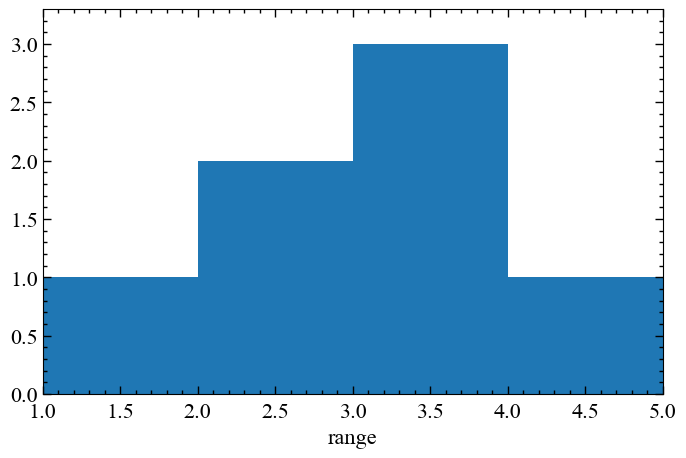

In [200]:
#Example
a =[1,2,3,3,3,2,6,5]
plt.hist(a,bins=np.arange(min(a),max(a)))
plt.xlabel("range")
f="/Home/siv30/wad005/master/GRB/source/test.pdf" #output path/name
#plt.savefig(f)
#crop_pdf(f)
plt.show()

## Function for exporting all light curves

In [ ]:
# export path to folder:
path_out_HED = '/Users/andreas/phys/master/GRB/pyplots/HED/'
path_out_LED = '/Users/andreas/phys/master/GRB/pyplots/LED/'

In [172]:
def export_plots():
    for grb_id in trig_dict_HED.keys():
        if len(trig_dict_HED[grb_id]) <= 1:
               plot_HED(grb_id=grb_id ,binsize = 16, export=True)
        else:
            concat_tus_HED, concat_erg_HED, T0 = concat_GRB(grb_id= grb_id, flag="HED")
            plot_HED(tus_arr= concat_tus_HED,T0= T0, binsize=32, export=True)
               
    for grb_id in trig_dict_LED.keys():
        if len(trig_dict_LED[grb_id]) <= 1:
               plot_LED(grb_id=grb_id ,binsize = 16, export=True)
        else:
            concat_tus_LED, concat_erg_LED, T0 = concat_GRB(grb_id=grb_id,flag="LED")
            plot_LED(tus_arr = concat_tus_LED, binsize=32, T0 = T0, export=True)

In [183]:
export_plots()

No overlapping data. Reason: ergs dont line up.....file num:  0  cutting at idx: : 17654
No overlapping data. Reason: ergs dont line up.....file num:  1  cutting at idx: : 18088
found index on firts try. ergs line up
No overlapping data. Reason: ergs dont line up.....file num:  3  cutting at idx: : 19210
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 180720 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 180720
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 180807 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 180807
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 181103 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 181103
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 181222 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 181222


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190117 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190117
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190206 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190206
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190305 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190305
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190320 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190320
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190404 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190404


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190420 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190420


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190501 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190501
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190606 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190606
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190615 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190615
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190706 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190706


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190813 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190813
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
found overlapping erg array. Concatenating two files ...
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190825 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190825


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190829 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190829


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190906 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 190906
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 191001 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 191001
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 191004 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 191004
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 191119 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 191119


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
found index on firts try. ergs line up
found index on firts try. ergs line up
found index on firts try. ergs line up
No overlapping data. Reason: ergs dont line up.....file num:  3  cutting at idx: : 9104
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 191221 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 191221


!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 191227 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 191227
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200111 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200111


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200224 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200224


!!! Error: Too many files!
/tmp/ipykernel_47855/3899758076.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(erg1[idx:] == erg2[0:len(erg1[idx:])]) == False:


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
No overlapping data. Reason: ergs dont line up.....file num:  0  cutting at idx: : 6203
No overlapping data. Reason: ergs dont line up.....file num:  1  cutting at idx: : 2534
No overlapping data. Reason: ergs dont line up.....file num:  2  cutting at idx: : 2864
No overlapping data. Reason: ergs dont line up.....file num:  3  cutting at idx: : 3059
No overlapping data. Reason: ergs dont line up.....file num:  4  cutting at idx: : 4996
found index on firts try. ergs line up
found index on firts try. ergs line up
found index on firts try. ergs line up
found index on firts try. ergs line up
found overlapping erg array. Concatenating two files ...
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200412 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200412


!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200415 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200415
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200423 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200423
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200521 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200521
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200525 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200525


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200605 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200605
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200716 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200716
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
found index on firts try. ergs line up


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200812 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200812
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200907 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200907
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200915 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200915
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200923 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200923


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200925 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 200925
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 201109 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 201109
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 201223 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 201223


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 201227 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 201227


!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
No overlapping data. Reason: ergs dont line up.....file num:  0  cutting at idx: : 6431
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210102 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210102
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210411 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210411


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210424 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210424


!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
found index on firts try. ergs line up
found overlapping erg array. Concatenating two files ...
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210607 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210607
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
found index on firts try. ergs line up
found index on firts try. ergs line up
found index on firts try. ergs line up
No overlapping data. Reason: ergs dont line up.....file num:  3  cutting at idx: : 16270
found index on firts try. ergs line up
found index on firts try. ergs line up
found index on firts try. ergs line up
found overlapping erg array. Concatenating two files ...
found index on firts try. ergs line up


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210619 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210619
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210701 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210701
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
found index on firts try. ergs line up
found index on firts try. ergs line up


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210702 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210702
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210724 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210724
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210903 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 210903


!!! Error: Too many files!
!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 211118 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 211118


!!! Error: Too many files!


PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
found index on firts try. ergs line up
No overlapping data. Reason: ergs dont line up.....file num:  1  cutting at idx: : 17602
found overlapping erg array. Concatenating two files ...
No overlapping data. Reason: ergs dont line up.....file num:  3  cutting at idx: : 24835
found index on firts try. ergs line up
found index on firts try. ergs line up
found index on firts try. ergs line up
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 211211 /Home/siv30/wad005/master/GRB/pyplots/HED/GRB 211211
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 181103 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 181103
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


No overlapping data. Reason: ergs dont line up.....file num:  0  cutting at idx: : 8574
found index on firts try. ergs line up
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 181227 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 181227
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190117 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190117
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190404 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190404
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190420 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190420
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190501 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190501
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190615 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190615
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190628 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190628
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190813 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190813
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


found overlapping erg array. Concatenating two files ...
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190825 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190825
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190906 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 190906
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191001 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191001
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191004 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191004
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191119 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191119
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


found index on firts try. ergs line up
found index on firts try. ergs line up
found index on firts try. ergs line up
No overlapping data. Reason: ergs dont line up.....file num:  3  cutting at idx: : 10824
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191221 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191221
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191227 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 191227
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200111 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200111
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200122 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200122
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200224 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200224
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


found index on firts try. ergs line up
found index on firts try. ergs line up
found index on firts try. ergs line up
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200412 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200412
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200415 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200415
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200423 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200423
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200525 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200525
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200605 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200605
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


found index on firts try. ergs line up
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200812 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200812
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200903 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200903
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200907 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200907
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200915 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200915
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200923 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 200923
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 201109 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 201109
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


No overlapping data. Reason: ergs dont line up.....file num:  0  cutting at idx: : 10157
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 210102 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 210102
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 210424 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 210424
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


found index on firts try. ergs line up
found index on firts try. ergs line up
pdfcrop --margins '1 1 1 1' /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 210607 /Home/siv30/wad005/master/GRB/pyplots/LED/GRB 210607
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.


!!! Error: Too many files!


# main function

In [ ]:
# On hold for now. 
"""def main(grb_id,binsize=10000, start_GRB, end_GRB):  # filename GRB ID
    # output array for tus_keep_multihit_LED, erg_keep_multihit_LED, multihit_indx_LED må modifiseres
    # Automake by making filename a list of filenames. Then the all the outout plots will be created

    # TODO:
    # Add the extra parameters to make the get_mean work
#os.mkdir("/Users/andreas/phys/master/MATLAB/pyplots")
    trig_dict = create_triggers_dict()
    try:
        output_dir = os.mkdir("/Home/siv30/wad005/master/GRB/MATLAB/pyplots/{}".format(grb_id)) #Creating owd folder for grb_id
    except FileExistsError:
        output_dir = "/Home/siv30/wad005//master/GRB/MATLAB/pyplots/{}".format(grb_id) #selecting path if it already exists


    if type(grb_id) != str:
        raise TypeError("Input is not string")
    elif grb_id not in trig_dict:
        raise LookupError("grb_id not in dictionary")
    else:
        try:
            LED_filename = trig_dict[grb_id][0]
            HED_filename = trig_dict[grb_id][1]
            if type(LED_filename) == float and math.isnan(LED_filename):
                print("LED file not found. Plotting only HED")
                plot_HED(HED_filename,output_dir,grb_id) #output path is not required
                
            elif type(HED_filename) == float and math.isnan(HED_filename):
                print("HED file not found. Plotting only LED")
                plot_LED(LED_filename,output_dir,grb_id)
            else:
                plot_LED(LED_filename,output_dir,grb_id)
                plot_HED(HED_filename,output_dir,grb_id)
        except:
            print("Something went wrong")
    """
    

# Purgatory

### Setup for debugging the find_cut_idx:



tus1, erg1, typ1, adr1, dau1, det1, DetCol1, date1 = read_matlab_file_with_BGO_data(trig_dict_HED["GRB200412"][1])
tus2, erg2, typ2, adr2, dau2, det2, DetCol2, date2 = read_matlab_file_with_BGO_data(trig_dict_HED["GRB200412"][2])

T0 = datetime.strptime(date1, "%Y-%b-%d %H:%M:%S.%f") #T0 of first file. Will be T0 for concat tus array

Adding the timeshift to all tus arrays from T0

deltaT = datetime.strptime(date2, "%Y-%b-%d %H:%M:%S.%f") - T0
tus2_shift = tus2 + float(deltaT.total_seconds())*1e6 #deltaT to all entries from T0

index_sort1 = np.argsort(tus1, kind="mergesort")
tus1_sort = tus1[index_sort1]
erg1_sort = erg1[index_sort1]

index_sort2 = np.argsort(tus2_shift, kind="mergesort")
tus2_sort = tus2_shift[index_sort2]
erg2_sort = erg2[index_sort2]


### Cut idx plot    
    if cut_idx != None: #plotting a specified range of the histogram in a color
        colors = cm.rainbow(np.linspace(0, 1, len(cut_idx)))
        
        fig0, ax1 = plt.subplots(
        1, 1, figsize=fig, sharex=True, sharey=False)
        
        for idx, c in zip(cut_idx, colors):
            ax1.hist(tus_HED, bins=np.arange(min(tus_HED), 
                                             max(tus_HED) + binsize, binsize),edgecolor= "black", histtype="step")
        
        
        

    if start_GRB and end_GRB != 0:
        mean = get_mean(HED_filename,binsize,tus_HED, start_GRB, end_GRB)
        ax1.axhline(y=mean, color="red", label= "Mean of bg: {} counts/bin \n First range [{} - {}] s \n 2nd: [{} - {}] s".format(
            np.round(mean,2), np.round(min(tus_HED)/1e6,3),start_GRB/1e6, end_GRB/1e6, np.round(max(tus_HED)/1e6,3)),linestyle='--'),
        ax1.legend()
        plt.show(),
    else:
        plt.show()

### Rename start_GRB to start_range. Same for end_GRB
def get_mean(matlab_filename, binsize, tus, start_GRB, end_GRB):
    
    """Function for getting the mean from the background.
    matlab_filename: <str> filename
    binsize: <int> given in us // 5ms = 5000 us 
    start & end_GRB given in us.
    -Finding ranges to compute the mean in each bin. """
    
    tus = np.sort(tus)
    range_1 =  find_closest(tus,start_GRB)
    range_2 = find_closest(tus,end_GRB)
    
    range_1_counts = np.histogram(tus[:range_1], bins=np.arange(
        min(tus[:range_1]), max(tus[:range_1]) + binsize, binsize))[0]
    
    range_2_counts = np.histogram(tus[range_2:], bins=np.arange(
        min(tus[range_2:]), max(tus[range_2:]) + binsize, binsize))[0]
    
    background_data = np.append(range_1_counts,range_2_counts)
    mean = np.mean(background_data)
    return mean